The goals of this notebook are to explore the relationship between prompt text/question and responses. Questions include:<br>
1 - Why are some questions answered better than others?<br>
2 - What is the most effective way to calculate closeness of a summary to prompt text?<br>
3 - Is there such thing as a summmary being too similar to the prompt?<br>
4...

In [2]:
from summary_eval.data import summary_df, prompts_df
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

From my last Notebook:

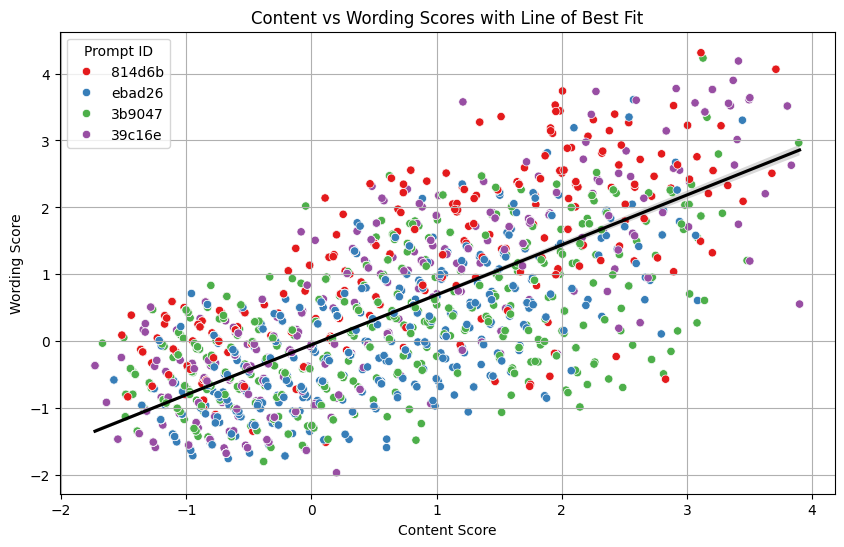

Summary Statistics for each Prompt ID:
            content             wording          
               mean       std      mean       std
prompt_id                                        
39c16e    -0.095457  0.969773 -0.140749  1.055695
3b9047     0.049579  1.106129 -0.068542  0.952708
814d6b     0.150306  1.124158  0.518733  1.107806
ebad26    -0.087906  0.990271 -0.299023  0.930270


In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df, x='content', y='wording', hue='prompt_id', palette='Set1')
sns.regplot(data=summary_df, x='content', y='wording', scatter=False, color='black')  
plt.title('Content vs Wording Scores with Line of Best Fit')
plt.xlabel('Content Score')
plt.ylabel('Wording Score')
plt.legend(title='Prompt ID')
plt.grid(True)
plt.show()

summary_stats = summary_df.groupby('prompt_id').agg({'content': ['mean', 'std'], 'wording': ['mean', 'std']})

print("Summary Statistics for each Prompt ID:")
print(summary_stats)

From this, we can attain a few things. Firstly when it comes to content the range between means is only 0.246 showing there is very little difference between the content of responses to the 4 prompts. The highest mean came from 8146db which also had the highest wording mean. Whilst 39c16e has the lowest mean for content, there are clearly some outliers as there appear to be more purple dots than any other colour around the 4 mark for content. The range between means for wording however is much larger at 0.818 with 814d6b having the highest mean. This indicates that people given this prompt were perhaps better at writing than those given other prompts.

39c16e	Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.<br>
3b9047	In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.<br>
814d6b	Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.<br>
ebad26	Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer.<br>

With ebad26 being the worst answered for both content and wording it is interesting that it is the only question that requests citations. Investigation into ebad26:

In [8]:
ebad26_df = summary_df[(summary_df['prompt_id'] == 'ebad26') | (summary_df['prompt_id'] == '3b9047')]
non_ebad26_df = summary_df[(summary_df['prompt_id'] != 'ebad26') & (summary_df['prompt_id'] != '3b9047')]

In [9]:
import numpy as np

# Function to count quotation marks
def count_quotation_marks(text):
    return text.count('"')

# Function to count commas
def count_commas(text):
    return text.count(',')

# Function to count brackets
def count_brackets(text):
    return text.count('[') + text.count(']') + text.count('(') + text.count(')')

# Apply the functions to create new columns
ebad26_df = ebad26_df.copy()
ebad26_df['quotation_marks'] = ebad26_df['text'].apply(count_quotation_marks)
ebad26_df['commas'] = ebad26_df['text'].apply(count_commas)
ebad26_df['brackets'] = ebad26_df['text'].apply(count_brackets)

non_ebad26_df = non_ebad26_df.copy()
non_ebad26_df['quotation_marks'] = non_ebad26_df['text'].apply(count_quotation_marks)
non_ebad26_df['commas'] = non_ebad26_df['text'].apply(count_commas)
non_ebad26_df['brackets'] = non_ebad26_df['text'].apply(count_brackets)

# Calculate correlation for ebad26_df
ebad26_corr_content = ebad26_df[['quotation_marks', 'commas', 'brackets', 'content']].corr()['content']
ebad26_corr_wording = ebad26_df[['quotation_marks', 'commas', 'brackets', 'wording']].corr()['wording']

# Calculate correlation for non_ebad26_df
non_ebad26_corr_content = non_ebad26_df[['quotation_marks', 'commas', 'brackets', 'content']].corr()['content']
non_ebad26_corr_wording = non_ebad26_df[['quotation_marks', 'commas', 'brackets', 'wording']].corr()['wording']

print("Correlation for ebad26_df - Content:")
print(ebad26_corr_content)
print("\nCorrelation for ebad26_df - Wording:")
print(ebad26_corr_wording)

print("\nCorrelation for non_ebad26_df - Content:")
print(non_ebad26_corr_content)
print("\nCorrelation for non_ebad26_df - Wording:")
print(non_ebad26_corr_wording)

Correlation for ebad26_df - Content:
quotation_marks    0.501556
commas             0.576579
brackets           0.284603
content            1.000000
Name: content, dtype: float64

Correlation for ebad26_df - Wording:
quotation_marks    0.273159
commas             0.319501
brackets           0.226702
wording            1.000000
Name: wording, dtype: float64

Correlation for non_ebad26_df - Content:
quotation_marks    0.429390
commas             0.501284
brackets           0.268335
content            1.000000
Name: content, dtype: float64

Correlation for non_ebad26_df - Wording:
quotation_marks    0.234668
commas             0.305555
brackets           0.156547
wording            1.000000
Name: wording, dtype: float64


The above indicates the use of quotation marks are more valuable when a prompt question asks for references. Brackets however are more impactful on content scores but less impactful for wording scores. This suggests words like 'cite' in the question should lead to quotation marks being more important for both content and wording scores.